In [1]:
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

sys.path.append("../../src")
from common import config
from data.initializer import DataLoaderSaver

%load_ext autoreload

In [2]:
paths = config.Paths(
    dataset_name="jobs_published",
    target_users_name="all",
)

In [3]:
%%time
from data.initializer import DataLoaderSaver

data = DataLoaderSaver()

data.load_interactions(paths.interactions)

interactions = data.interactions

CPU times: user 1min 40s, sys: 39 s, total: 2min 19s
Wall time: 2min 42s


In [4]:
interactions[:5]

,user,item,event,timestamp
0,27901,56865,click,1581465600
1,124480,115662,click,1581465600
2,159509,5150,click,1581465600
3,188861,109981,click,1581465600
4,207348,88746,click,1581465600


# Basics statistics of the dataset

In [5]:
n_users = interactions["user"].nunique()
n_items = interactions["item"].nunique()
n_interactions = len(interactions)

interactions_per_user = interactions.groupby("user").size()
interactions_per_item = interactions.groupby("item").size()

print(f"We have {n_users} users, {n_items} items and {n_interactions} interactions.\n")

print(
    f"Data sparsity (% of missing entries) is {round(100 * (1- n_interactions / (n_users * n_items)), 4)}%.\n"
)

print(
    f"Average number of interactions per user is {round(interactions_per_user.mean(), 3)}\
    (standard deviation {round(interactions_per_user.std(ddof=0),3)}).\n"
)

print(
    f"Average number of interactions per item is {round(interactions_per_item.mean(), 3)}\
    (standard deviation {round(interactions_per_item.std(ddof=0),3)}).\n"
)

We have 3295942 users, 185395 items and 65502201 interactions.

Data sparsity (% of missing entries) is 99.9893%.

Average number of interactions per user is 19.874    (standard deviation 47.762).

Average number of interactions per item is 353.312    (standard deviation 624.773).



# Interactions distribution per user

In [6]:
def compute_quantiles(series, quantiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]):
    return pd.DataFrame(
        [[quantile, series.quantile(quantile)] for quantile in quantiles],
        columns=["quantile", "value"],
    )


print("Interactions distribution per user:")
compute_quantiles(interactions_per_user)

Interactions distribution per user:


,quantile,value
0,0.01,1.0
1,0.10,1.0
2,0.25,2.0
3,0.50,6.0
4,0.75,18.0
5,0.90,46.0
6,0.99,221.0


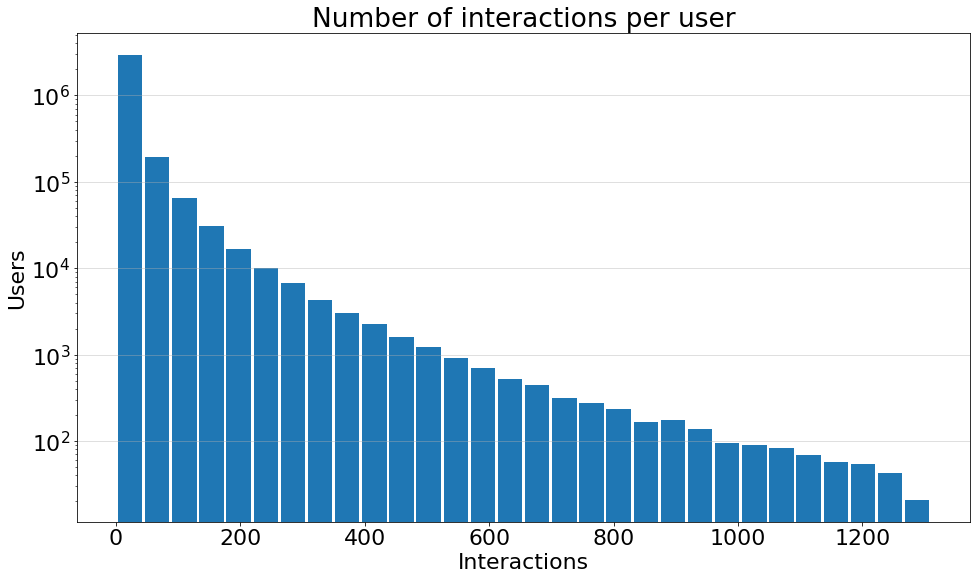

In [7]:
def plot_interactions_distribution(series, aggregation="user", ylabel="Users", bins=30):
    matplotlib.rcParams.update({"font.size": 22})
    series.plot.hist(bins=bins, rwidth=0.9, logy=True, figsize=(16, 9))
    plt.title(f"Number of interactions per {aggregation}")
    plt.xlabel("Interactions")
    plt.ylabel(ylabel)
    plt.grid(axis="y", alpha=0.5)


plot_interactions_distribution(interactions_per_user, "user", "Users")

# Interactions distribution per item

In [8]:
print("Interactions distribution per item:")
compute_quantiles(interactions_per_item)

Interactions distribution per item:


,quantile,value
0,0.01,1.00
1,0.10,1.00
2,0.25,3.00
3,0.50,137.00
4,0.75,428.00
5,0.90,950.00
6,0.99,2944.06


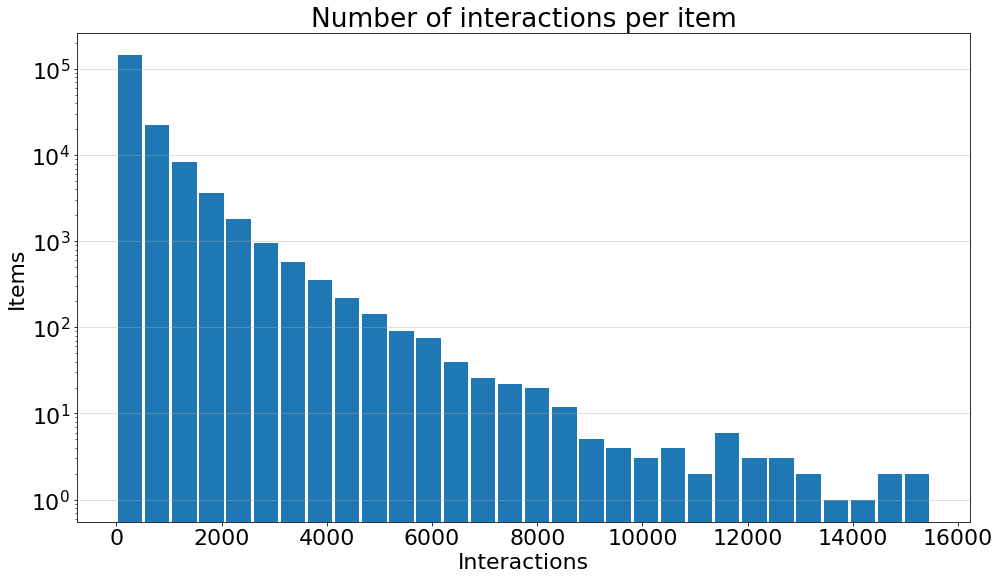

In [9]:
plot_interactions_distribution(interactions_per_item, "item", "Items")

# Events distribution

In [10]:
event_frequency = pd.DataFrame(
    interactions["event"].value_counts() / len(interactions)
).rename(columns={"event": "frequency"})

event_frequency["frequency"] = event_frequency["frequency"].apply(
    lambda x: f"{round(100*x,3)}%"
)
event_frequency

,frequency
click,89.794%
contact_phone_click_1,2.628%
bookmark,2.511%
chat_click,2.136%
contact_chat,1.448%
contact_partner_click,0.701%
contact_phone_click_2,0.679%
contact_phone_click_3,0.103%


# Interactions over time

In [11]:
def unix_to_day(timestamps):
    min_timestamp = timestamps.min()
    seconds_in_day = 60*60*24
    return (timestamps - min_timestamp)//seconds_in_day + 1


interactions["day"] = unix_to_day(interactions["timestamp"])

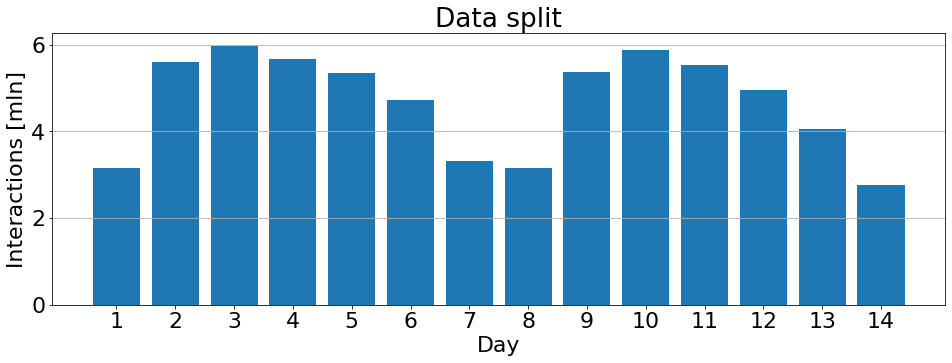

In [12]:
def plot_interactions_over_time(series):
    freq = series.value_counts()
    labels, counts = freq.index, freq.values/10**6
    
    matplotlib.rcParams.update({"font.size": 22})
    plt.figure(figsize=(16,5))
    plt.bar(labels, counts, align='center')
    plt.gca().set_xticks(labels)
    plt.title(f"Data split")
    plt.xlabel("Day")
    plt.ylabel("Interactions [mln]")
    plt.grid(axis="y")
    
plot_interactions_over_time(interactions["day"])